In [1]:
# map torch.tensor.cuda to dummy function to prevent errors on systems without a GPU
import torch

def dummy_cuda(self, device=None, non_blocking=False):
    return self  # just return the same tensor (on CPU)

torch.Tensor.cuda = dummy_cuda
torch.nn.Module.cuda = dummy_cuda

In [2]:
%load_ext autoreload
%autoreload 1 
%aimport Waven.Analysis_Utils

In [3]:
from Waven import WaveletGenerator as wg
from Waven import Analysis_Utils as au
from Waven import LoadPinkNoise as lpn
from Waven import zebraGUI as ui

In [4]:
# import waven.WaveletGenerator as wg
# import waven.Analysis_Utils as au
# import waven.LoadPinkNoise as lpn
# import waven.zebraGUI as ui
import numpy as np
import gc
import os

from pathlib import Path
# from pynwb import NWBHDF5IO
import numpy as np
import matplotlib.pyplot as plt
from dandi import dandiapi, download
import os   
import pandas as pd
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from pynwb import NWBHDF5IO

from tqdm import tqdm

import pickle
%load_ext autoreload
%autoreload 1 
%aimport utils
import utils

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# # Set Data dir in utils!

# dandiset_id =  utils.dandiset_id
# dandi_dirpath = utils.dandi_dirpath
# dandi_filepath = utils.dandi_filepath
# filenames = utils.filenames

# DATAFILE_NAME = filenames[0]
# nwb = utils.load_dandi(DATAFILE_NAME, dandiset_id, dandi_dirpath)
# nwb

In [6]:
# probe_a, probe_b, probe_c, probe_d = utils.load_probe_dicts(filenames)
# df_units = nwb.units.to_dataframe()
# sua_c = [k for k in probe_c['sub-820454/'+DATAFILE_NAME] if df_units.iloc[k]['decoder_label']=='sua']
# len(sua_c)

In [7]:
# df_units

In [8]:
# utils.derivitive_dir

In [9]:
# idx_filter_out = np.arange(len(df_units))
# idx_filter_out = np.setdiff1d(idx_filter_out, sua_c)
# df_units_ana = df_units.drop(index=idx_filter_out)
# df_units_ana = df_units_ana[df_units_ana['decoder_label'] == 'sua']
# df_units_ana.reset_index(inplace=True)
# df_units_ana

In [10]:
spike_times_dir = utils.derivitive_dir+'spike_times/'

# for idx in sua_c:
#     spike_times = nwb.units['spike_times'][idx]
#     unit_name = df_units.iloc[idx]['unit_name']
#     np.save(spike_times_dir + f'spike_times_unit_{unit_name}.npy', spike_times)

    

In [11]:
# loc_x = df_units_ana['estimated_x']
# loc_y = df_units_ana['estimated_y']
# print(loc_x.shape, loc_y.shape)

# pos = np.vstack((loc_x, loc_y))
# print(pos.shape)
# np.save(spike_times_dir + f'pos.npy', pos)


In [12]:
files_in_spike_times_dir = os.listdir(spike_times_dir)
print(files_in_spike_times_dir)

"""
Parameters Gabor Library:
    N_thetas (int): number of orientatuion equally spaced between 0 and 180 degree.
    Sigmas (list): standart deviation of theb gabor filters expressed in pixels (radius of the gaussian half peak wigth).
    Frequencies (list): spatial frequencies expressed in pixels per cycles.
    Phases (list): 0 and pi/2.
    NX (int): number of azimuth positions (pix) (x shape of the downsampled stimuli).
    NY (int): number of elevation positions (pix) (y shape of the downsampled stimuli).
    Save Path (string): where to save the gabor library

Parameters alignement:
    Dirs (string): where the raw data are.
    Experiment Info: (mouse name, data, experiment number)
    Number of Planes (int): number of acquisition planes.
    Block End (int): timeframe where the experiment starts.
    Number of Frames (int): number of frames stim 30 Hz -> 1800 frame/min.
    Number of Trials to Keep(int): Number of Trials to Keep.

Parameters analysis:
    screen_x: stimulus screen x size inn pixels.
    screen_y: stimulus screen y size inn pixels.
    NX (int): number of azimuth positions (pix) (x shape of the downsampled stimuli).
    NY (int): number of elevation positions (pix) (y shape of the downsampled stimuli).
    Resolution (float): microscope resolution (um per pixels)
    Sigmas (list): standart deviation of theb gabor filters expressed in pixels (radius of the gaussian half peak wigth).
    Visual Coverage (list): [azimuth left, azimuth right, elevation top , elevation bottom] in visual degree.
    Analysis Coverage (list): [azimuth left, azimuth right, elevation top , elevation bottom] in visual degree.
    Movie Path: path to the stimulus (.mp4)
    Library Path: path to Gabor library (same as save path if ran)
    Spks Path (opt): path to the spks.npy file to skip the alignement procedure, if set ignores Parameter alignment
"""

# List of default parameters for the Gabor Library
gabor_param={
    "N_thetas":"4",
    "Sigmas": "[2, 3, 4, 5, 6, 8]",
    # "Frequencies": "[0.015, 0.04, 0.07, 0.1]",
    "Frequencies": "0.072",
    "Phases": "[0, 90]",
    # "NX": "135",
    # "NY": "54",
    "NX": "107", # TODO
    "NY": "85",  # TODO
    "Save Path":"../../../waven/gabors_library.npy"
}

# List of default parameters
param_defaults = {
    "Path Directory": "../../rawdata/allen_open_scope/stimulus/zebra/",
    "Dirs": "../../rawdata/allen_open_scope/sub-820454/",
    "Experiment Info": "('820454', '2025-11-05', 3)",
    "Number of Planes": "1",
    "Block End": "0",
    "screen_x":"1072",
    "screen_y":"848",
    # "NX": "135", # TODO
    # "NY": "54",  # TODO
    # "NX": "120", # TODO
    # "NY": "95",  # TODO
    "Resolution":"1.3671",
    "Sigmas": "[2, 3, 4, 5, 6, 8]",
    # "Frequencies": "[0.015, 0.04, 0.07, 0.1]",
    # "Frequencies": "0.08",
    # "Visual Coverage":"[-135, 45, 34, -34]", # TODO
    "Visual Coverage":"[-60, 60, 47.5, -47.5]", # TODO
    # "Analysis Coverage":"[-135, 45, 34, -34]", # TODO
    "Analysis Coverage": "[-60, 60, 47.5, -47.5]",
    "Number of Frames": "9000",
    "Number of Trials to Keep": "1",
    "Movie Path": "../../rawdata/allen_open_scope/stimulus/zebra/zebra_allen_screen_tscale_30_scale_10.mp4",
    "Library Path": "../../../waven/gabors_library.npy",
    "Spks Path": utils.derivitive_dir+'spike_times/'+files_in_spike_times_dir[0],
}



sigmas = eval(gabor_param["Sigmas"])
nx = int(gabor_param["NX"])
ny = int(gabor_param["NY"])
n_theta = int(gabor_param["N_thetas"])
offsets= eval(gabor_param["Phases"])
path_save = gabor_param["Save Path"]
xs = np.arange(nx)
ys = np.arange(ny)
thetas = np.array([(i * np.pi) / n_theta for i in range(n_theta)])
sigmas = np.array(sigmas)
offsets=np.array(offsets)
f =  eval(gabor_param["Frequencies"])

path_directory = param_defaults["Path Directory"]
dirs = [param_defaults["Dirs"]]
exp_info = eval(param_defaults["Experiment Info"])
sigmas = eval(param_defaults["Sigmas"])
sigmas=np.array(sigmas)
visual_coverage = eval(param_defaults["Visual Coverage"])
analysis_coverage = eval(param_defaults["Analysis Coverage"])
n_planes = int(param_defaults["Number of Planes"])
block_end = int(param_defaults["Block End"])
screen_x = int(param_defaults["screen_x"])
screen_y = int(param_defaults["screen_y"])
ns = len(sigmas)
resolution=float(param_defaults["Resolution"])
spks_path = param_defaults["Spks Path"]
nb_frames = int(param_defaults["Number of Frames"])
n_trial2keep = int(param_defaults["Number of Trials to Keep"])
movpath = param_defaults["Movie Path"]
lib_path = param_defaults["Library Path"]
screen_ratio = abs(visual_coverage[0]-visual_coverage[1])/nx
xM, xm, yM, ym = analysis_coverage

pathdata = os.path.join(os.path.join(os.path.join(dirs[0] , exp_info[0]) , exp_info[1]) , str(exp_info[2]))
pathsuite2p = os.path.join(pathdata , 'suite2p')

deg_per_pix=abs(xM-xm)/nx
sigmas_deg=np.trunc(2*deg_per_pix*sigmas*100)/100


## define visual coverage for the analysis
if (visual_coverage!=analysis_coverage):
    visual_coverage=np.array(visual_coverage)
    analysis_coverage=np.array(analysis_coverage)
    ratio_x=1-((visual_coverage[0]-visual_coverage[1])-(analysis_coverage[0]-analysis_coverage[1]))/(visual_coverage[0]-visual_coverage[1])
    ratio_y=1-((visual_coverage[2]-visual_coverage[3])-(analysis_coverage[2]-analysis_coverage[3]))/(visual_coverage[2]-visual_coverage[3])
else:
    ratio_x=1
    ratio_y=1

print(ratio_x, ratio_y)

['spike_times_unit_24f46e34-4ad5-4e60-9c75-d73eba368146.npy', 'spike_times_unit_70d9cab6-27ec-405c-91f8-e1f1cd995412.npy', 'spike_times_unit_5bfdc651-96c4-43e6-9590-0667a5eeb681.npy', 'spike_times_unit_641e7bd3-0b0e-42be-ab33-05dd0160ee77.npy', 'spike_times_unit_7c5739fb-a067-48e7-be6d-56e7a65541ba.npy', 'spike_times_unit_6fe62cab-5425-4c71-86a8-7849f55da26f.npy', 'spike_times_unit_7db9d627-c668-4bf3-b922-49f3bbbc0e39.npy', 'spike_times_unit_ef656b8e-239f-476e-89b2-7888c6e6d06f.npy', 'spike_times_unit_9a9c6bb8-45dd-4110-b4e9-73f0e6a56ae9.npy', 'spike_times_unit_970e6e9b-aaa0-4116-812d-6b03a8c11e8d.npy', 'spike_times_unit_03f841a3-e1b8-4fba-94ac-316783f1665b.npy', 'spike_times_unit_710fdb9a-2721-4f56-b907-91c2df244f31.npy', 'spike_times_unit_c63ffd45-7a2c-4da0-82b8-43226f3020fc.npy', 'spike_times_unit_fa292709-5c6a-4295-9ab0-5ec58ed6f074.npy', 'spike_times_unit_e15874cb-e1fb-4920-a9b8-2c2f51d47f22.npy', 'spike_times_unit_867a0c05-e483-4bda-bef4-a835e3facfeb.npy', 'spike_times_unit_e158c

In [13]:
f

0.072

In [14]:
# create a new gabor library
if not os.path.exists(path_save):
    freq=True
    L = wg.makeFilterLibrary(xs, ys, thetas, sigmas, offsets, f, freq=freq)
    np.save(path_save, L)
    lib_path=path_save

### Downsampling and adjusting the range of visual coverage to your analysis:

In [15]:
print(f'path: {movpath}')
print(f'vis cov.: {visual_coverage}')
print(f'ana cov.: {analysis_coverage}')
print(f'shape: {(ny, nx)}')
print(f'ratios: {(ratio_x, ratio_y)}')

downsampled_path = movpath[:-4]+'_downsampled.npy'
RECOMPUTE = True

if not os.path.exists(downsampled_path) and RECOMPUTE:
    wg.downsample_video_binary(os.path.abspath(movpath),
                            np.array(visual_coverage),  
                            np.array(analysis_coverage), 
                            shape=(ny, nx), 
                            chunk_size=500, 
                            ratios=(ratio_x, ratio_y)
                            )

path=os.path.dirname(movpath)
videodata=np.load(movpath[:-4]+'_downsampled.npy')
print('Shape videodata', videodata.shape)

path: ../../rawdata/allen_open_scope/stimulus/zebra/zebra_allen_screen_tscale_30_scale_10.mp4
vis cov.: [-60, 60, 47.5, -47.5]
ana cov.: [-60, 60, 47.5, -47.5]
shape: (85, 107)
ratios: (1, 1)
Shape videodata (9000, 85, 107)


In [18]:
downsampled_path

'../../rawdata/allen_open_scope/stimulus/zebra/zebra_allen_screen_tscale_30_scale_10_downsampled.npy'

In [ ]:
waveletDecomposition_files = os.listdir(os.path.dirname(path_directory))
waveletDecomposition_files = [f for f in waveletDecomposition_files if f[:3] == 'dwt']

folder_path = '../../rawdata/allen_open_scope/stimulus/zebra'

RECOMPUTE = True
if len(waveletDecomposition_files) < 2 and RECOMPUTE:
    # wg.waveletDecomposition(videodata=videodata, phase=0, sigmas=sigmas, folder_path=folder_path, library_path=lib_path)
    wg.waveletDecomposition(videodata=videodata, phase=1, sigmas=sigmas, folder_path=folder_path, library_path=lib_path)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [17]:
## run data alignment if the neural and stimulis data are acquired with CortexLab system
# spks, spks_z, neuron_pos=lpn.loadSPKMesoscope(exp_info, dirs, pathsuite2p, block_end, n_planes, nb_frames, threshold=1.25, last=True,  method='frame2ttl')

## otherwise
spks=np.load(spks_path)
parent_dir = os.path.dirname(spks_path)
neuron_pos=np.load(os.path.join(parent_dir, 'pos.npy'))

neuron_pos = np.zeros((1,2))  # dummy value for neuron_pos
## converts neuron position in microns
neuron_pos=lpn.correctNeuronPos(neuron_pos, resolution)
neuron_pos

array([[0., 0.]])

In [18]:
df_zebra = nwb.intervals['Zebra_presentations'].to_dataframe()
df_zebra.columns
# df_zebra[df_zebra['TrialInSequence']=='1.0']
# df_zebra['TrialInSequence']

Index(['start_time', 'stop_time', 'stim_name', 'stim_type', 'stim_block',
       'Orientation', 'SpatialFrequency', 'TemporalFrequency', 'contrast',
       'phase', 'DiameterX', 'DiameterY', 'X', 'Y', 'Duration', 'Delay',
       'BlockNumber', 'BlockLabel', 'TrialNumber', 'SequenceNumber',
       'TrialInSequence', 'TrialType', 'BlockType', 'stim_index',
       'timeseries'],
      dtype='object')

In [ ]:
## the spikes data have to be time registered to the stimulus frames
## MR Only one trial thus no repeatability
# respcorr_zebra = au.repetability_trial3(spks, neuron_pos, plotting=True)

wavelets0, wavelets1, wavelet_c = lpn.coarseWavelet(path=path_directory,
                                                    downsampling=False, 
                                                    nx0=nx, 
                                                    ny0=ny, 
                                                    nx=13, 
                                                    ny=11, 
                                                    no=n_theta, 
                                                    ns=ns,
                                                    chunk_size=200
                                                        )
print(wavelets0.shape, wavelets1.shape, wavelet_c.shape)

loading wavelets...
already downsampled
(9000, 27, 11, 8, 6, 1) (9000, 27, 11, 8, 6, 1) (9000, 27, 11, 8, 6, 1)


--- 
### Results Gabor Spikecounts

In [98]:
df_gabors = utils.load_all_gabor_rf_results()
df_gabors = df_gabors[df_gabors['p_value']<0.05]
df_gabors.reset_index(inplace=True, drop=True)
df_gabors

,unit_name,file,orientation,mean_response,z_score_response,p_value,probe,mean_rate
0,5fd02187-7022-46fa-bcb4-61bda1182c60,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",0.000999,d,0.000000
1,10d3b09d-4150-429e-b23a-3dfa65babd33,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[0.0, 0.0, 1.1983753, 4.793614, 0.0, 0.0, 0.0...","[[-0.385255, -0.385255, -0.2300036, 0.2357652,...",0.000999,d,2.973758
2,9f3e226a-ca2d-48bb-8d9d-41cbf896a478,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[3.595191, 1.1983753, 1.1983706, 1.1984035, 2...","[[0.071104355, -0.4524056, -0.45240662, -0.452...",0.047952,c,3.269650
3,a9351c27-ded6-4f15-8120-f1d8acfdccc0,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",0.000999,d,0.000000
4,c6014eb9-eba7-46bd-88ea-dc1de8d756dc,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[9.5871315, 2.3967507, 2.3967302, 4.793595, 2...","[[-0.3073539, -0.8304696, -0.8304711, -0.65609...",0.015984,c,13.811802
...,...,...,...,...,...,...,...,...
493,b19f27f5-1314-42c7-8b67-0d970ddf57bf,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",0.000999,d,0.000000
494,5c4199b9-a557-4936-9ecf-5d719a3cf626,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[-0.17465757, -0.17465757, -0.17465757, -0.17...",0.004995,d,0.179181
495,5f50a1d3-8ba8-40b4-a58b-f4f02df2e29d,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[1.1983651, 0.0, 0.0, 0.0, 4.7935576, 1.19840...","[[-0.20282473, -0.4741176, -0.4741176, -0.4741...",0.000999,d,2.094290
496,572d9c67-8c1e-4b4e-946c-2a98b5f8c2f7,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...",0.000999,c,0.000000


In [96]:
df_gabors['orientation'].unique()

array([1.5707964], dtype=float32)

--- 
### Results STA

In [20]:
pd.__version__

'2.3.1'

In [21]:
RESULTS_DIR = '../../results/allen_open_scope/rf/sta/zebra/units/'
res_file = RESULTS_DIR+'../sta_zebra_units.csv'
df_res_sta = pd.read_csv(res_file)

median_n_spikes = df_res_sta['n_spikes'].median()

df_res_sta.drop(df_res_sta[df_res_sta['n_spikes'] < median_n_spikes].index, inplace=True)
df_res_sta = df_res_sta.sort_values(by='max_entropy', ascending=False)
df_res_sta.reset_index(drop=True, inplace=True)
df_res_sta['probe'] = df_res_sta['file'].apply(lambda x: x.split('__')[1])
df_res_sta['origin_file'] = df_res_sta['file'].apply(lambda x: x.split('__')[0])


df_res_sta[:5]

,unit_name,n_spikes,file,max_entropy,max_contrast,x,y,probe,origin_file
0,7e794edb-4a80-4089-95f4-a3bd5e62462f,6270,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.369932,0.171451,387.000000,157.000000,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...
1,5d77b1fc-ad53-44c1-8d6d-d48488f4cccb,3864,sub-820454_ses-ecephys-820454-2025-11-05-15-21...,1.320734,0.207816,402.333333,822.333333,probe-c,sub-820454_ses-ecephys-820454-2025-11-05-15-21...
2,46e619d9-8a85-4edf-b416-022d2aa1f844,4007,sub-820454_ses-ecephys-820454-2025-11-05-15-21...,1.252795,0.262790,427.000000,504.500000,probe-c,sub-820454_ses-ecephys-820454-2025-11-05-15-21...
3,bab57985-6c06-4470-8ac7-3c8cc9f5bf41,4340,sub-820454_ses-ecephys-820454-2025-11-06-16-00...,1.230664,0.184793,175.500000,360.500000,probe-c,sub-820454_ses-ecephys-820454-2025-11-06-16-00...
4,3df4c9de-edb1-44a9-870e-4cad737be475,3469,sub-820454_ses-ecephys-820454-2025-11-06-16-00...,1.226645,0.191698,500.000000,322.000000,probe-c,sub-820454_ses-ecephys-820454-2025-11-06-16-00...


Build intersection of results dataframes 


In [71]:
common_units = pd.merge(df_res_sta, df_gabors, on='unit_name', how='inner')
common_units

,unit_name,n_spikes,file_x,max_entropy,max_contrast,x,y,probe_x,origin_file,file_y,orientation,mean_response,z_score_response,p_value,probe_y,mean_rate
0,26751dfc-9ca0-41f1-9675-dae45e94c595,4112,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.121044,0.177529,416.0,519.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[0.0, 1.1983753, 3.595126, 1.1983798, 1.19837...","[[-0.33909482, -0.057225045, 0.50651455, -0.05...",0.000999,c,1.441669
1,c390f6eb-1b3b-421a-b119-3ba22609ef8c,4282,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.101270,0.151565,699.0,648.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[19.17432, 10.785442, 7.1902113, 8.38865, 11....","[[0.47350022, -0.22383004, -0.52268565, -0.423...",0.007992,c,13.478116
2,d180d126-2430-4924-8f0e-578db2ebd6af,6218,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.099747,0.214217,228.0,659.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[10.785535, 20.372578, 21.570827, 37.15007, 3...","[[-1.1542382, -0.6004299, -0.53121144, 0.36874...",0.000999,c,30.766691
3,7a0edbc4-6348-45fc-b376-232084498bcc,7732,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.061960,0.153647,278.0,649.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[20.37276, 16.777403, 23.967623, 16.777431, 2...","[[-0.32458955, -0.5656624, -0.08355011, -0.565...",0.021978,c,25.213688
4,66b17470-02b5-4a58-9bfe-5f6c3d534e37,5761,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.056861,0.137129,254.0,649.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[4.7935367, 15.579011, 7.1902266, 13.182244, ...","[[-1.0451146, -0.23286304, -0.8646205, -0.4133...",0.001998,c,18.671080
5,aaed78e2-f0f0-433f-9e15-4d1133cc633d,3911,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.049062,0.130913,167.0,634.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[3.5952294, 3.595135, 14.380666, 9.587113, 7....","[[-0.9077868, -0.90779704, 0.25777835, -0.2602...",0.001998,c,11.995340
6,48c3717f-8794-438d-a6dc-0aba4b4aceb9,4640,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.024942,0.120259,438.0,417.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[8.388747, 13.182258, 15.578911, 9.587113, 14...","[[-0.5540261, 0.103238635, 0.43185696, -0.3897...",0.000999,c,12.429326
7,c6014eb9-eba7-46bd-88ea-dc1de8d756dc,5173,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.017003,0.123139,301.0,655.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[9.5871315, 2.3967507, 2.3967302, 4.793595, 2...","[[-0.3073539, -0.8304696, -0.8304711, -0.65609...",0.015984,c,13.811802
8,4ae67813-fd92-4ac6-8ff6-417258acfab0,5857,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.009192,0.116613,1071.0,473.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[14.380745, 11.983875, 1.1983753, 5.9920173, ...","[[-0.002032322, -0.17735982, -0.96630335, -0.6...",0.022977,c,14.408529
9,f9b7cc9f-2ee7-4731-82e7-37439be72613,7497,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.004615,0.100840,1067.5,473.0,probe-c,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,sub-820454_ses-ecephys-820454-2025-11-04-14-59...,1.570796,"[[43.14216, 27.562817, 16.777164, 19.174236, 2...","[[0.43036374, -0.18647122, -0.61350894, -0.518...",0.007992,c,32.272503


In [100]:
nwb_file = common_units['origin_file'].unique()[0]
nwb = utils.load_dandi(nwb_file, dandiset_id, dandi_dirpath)
df_units = nwb.units.to_dataframe()
df_zebra = nwb.intervals['Zebra_presentations'].to_dataframe()

Processing file: sub-820454_ses-ecephys-820454-2025-11-04-14-59-22_ecephys.nwb
File already exists


/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

In [103]:
spike_times

SpikeTrain containing 801 spikes; units s; datatype float64 
time: 4408.887975360903 s to 5263.673598346586 s

In [108]:
import neo
import quantities as pq

idxs = [0] 


neuron_rate_to_zebra_frames = []
# for idx in idxs: 
# for idx in tqdm(range(len(common_units))):
for idx in tqdm(range(len(df_gabors))):
    # unit_name = common_units.loc[idx, 'unit_name']
    unit_name = df_gabors.loc[idx, 'unit_name']
    spike_times = df_units.loc[df_units['unit_name']==unit_name, 'spike_times'].values[0]
    spike_times = neo.core.SpikeTrain(spike_times, t_start=spike_times[0], t_stop=spike_times[-1], units=pq.s)

    tmp = []
    for i, row in df_zebra.iterrows():
        try:
            start_time = row['start_time']
            stop_time = row['stop_time']
            rate = len(spike_times.time_slice(start_time, stop_time))/((stop_time - start_time)*pq.s)
            rate = rate.rescale('Hz').magnitude
        except:
            rate = 0
        tmp.append(rate)
    neuron_rate_to_zebra_frames.append(np.array(tmp))
neuron_rate_to_zebra_frames = np.array(neuron_rate_to_zebra_frames)
neuron_rate_to_zebra_frames.shape

 68%|██████▊   | 338/498 [12:28<05:54,  2.22s/it]


KeyboardInterrupt: 

In [62]:
neuron_pos = np.zeros((1,2))  # dummy value for neuron_pos

SpikeTrain containing 87244 spikes; units s; datatype float64 
time: 21.513456091247118 s to 5348.338274704169 s

In [63]:
wavelet_c.reshape(9000, -1).shape

(9000, 14256)

In [64]:
## runs correlation analysis
rfs_zebra = au.PearsonCorrelationPinkNoise(stim=wavelet_c.reshape(9000, -1), 
                                           resp=neuron_rate_to_zebra_frames.reshape(9000, -1),
                                           neuron_pos=neuron_pos, 
                                           nx=27, 
                                           ny=11, 
                                           ns=ns, 
                                           visual_coverage=analysis_coverage, 
                                           screen_ratio=screen_ratio, 
                                           sigmas=sigmas_deg,
                                           plotting=False,
                                           )

torch.Size([14277, 14277])
(21, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]


In [67]:
rfs_zebra[0].shape

(21, 27, 11, 8, 6)

In [73]:
rfs_zebra[1]

[array([ 7, 17, 17,  5,  5,  5,  4, 17, 17, 13, 12, 17, 13, 19, 13, 10, 10,
        10, 22, 21, 16]),
 array([6, 1, 4, 0, 2, 2, 3, 4, 4, 4, 4, 4, 4, 9, 4, 4, 5, 5, 5, 4, 3]),
 array([5, 0, 1, 0, 3, 4, 3, 5, 5, 4, 5, 5, 4, 6, 4, 4, 4, 5, 6, 6, 4]),
 array([3, 2, 2, 3, 1, 1, 3, 2, 2, 2, 3, 3, 3, 1, 2, 2, 2, 3, 3, 3, 1])]

In [37]:
## plot neuron receptive field
idx=0
au.Plot_RF(rfs_zebra[0][idx],4, title=np.max(rfs_zebra[0][idx]))

In [ ]:
## plots neuron tuning curves
tuning_curve=Waven.Analysis_Utils.PlotTuningCurve(rfs_zebra, idx, analysis_coverage, sigmas_deg, screen_ratio)

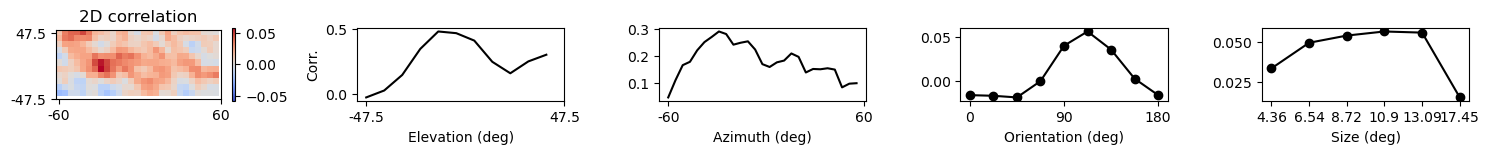

In [95]:
%matplotlib inline
fig, ax = plt.subplots(1, 5, figsize=(15, 1.5))
tuning_curve  = Waven.Analysis_Utils.PlotTuningCurve_Marcel(rfs_zebra, 
                                                    0, 
                                                    analysis_coverage, 
                                                    sigmas_deg, 
                                                    screen_ratio, 
                                                    canvas=(fig, ax),
                                                    show=True
                                                    )
# tuning_curve  = Waven.Analysis_Utils.PlotTuningCurve_Marcel(rfs_zebra, 
#                                                     idx, 
#                                                     analysis_coverage, 
#                                                     sigmas_deg, 
#                                                     screen_ratio, 
#                                                     canvas=(fig, ax),
#                                                     show=True
#                                                     )

fig.tight_layout()

---

In [133]:
unit_name

'7e794edb-4a80-4089-95f4-a3bd5e62462f'

In [ ]:
df_res_sta[(df_res_sta['unit_name'] == unit_name) & ]

In [ ]:
# Set Data dir in utils!

N = 100
df_tmp = df_res_sta[:N]

unique_files = df_tmp['origin_file'].unique()

elevations = []
azimuths = []
orientations = []
sizes = []
unit_names_list = []
files_list = []

for dandi_filepath in unique_files:

    dandiset_id =  utils.dandiset_id
    dandi_dirpath = utils.dandi_dirpath
    nwb = utils.load_dandi(dandi_filepath, dandiset_id, dandi_dirpath)
    df_units = nwb.units.to_dataframe()

    df_tmp_sub = df_tmp[df_tmp['origin_file'] == dandi_filepath]
    unit_names = df_tmp_sub['unit_name']

    for unit_name in unit_names:
        print(f'>>>> {df_tmp[df_tmp["unit_name"] == unit_name].index[0]+1}/{N} - {unit_name} <<<<')

        #load precomputed results
        df_pre = pd.read_csv('../../results/allen_open_scope/rf/waven/zebra/precomputed_waven_zebra_units.csv')
        if unit_name in df_pre['unit_name'].values:
            elevations.append(df_pre[df_pre['unit_name'] == unit_name]['waven_max_elevation'].values[0])
            azimuths.append(df_pre[df_pre['unit_name'] == unit_name]['waven_max_azimuth'].values[0])
            orientations.append(df_pre[df_pre['unit_name'] == unit_name]['waven_max_orientation'].values[0])
            sizes.append(df_pre[df_pre['unit_name'] == unit_name]['waven_max_size'].values[0])
            unit_names_list.append(unit_name)
            files_list.append(dandi_filepath)
            continue

        spike_times = df_units.loc[df_units['unit_name'] == unit_name, 'spike_times'].values[0]
        spike_times = neo.core.SpikeTrain(spike_times, t_start=spike_times[0], t_stop=spike_times[-1], units=pq.s)

        tmp = []
        for i, row in df_zebra.iterrows():
            start_time = row['start_time']
            stop_time = row['stop_time']
            rate = len(spike_times.time_slice(start_time, stop_time))/((stop_time - start_time)*pq.s)
            rate = rate.rescale('Hz').magnitude
            tmp.append(rate)
        neuron_rate_to_zebra_frames = np.array(tmp).reshape(1, -1)


        neuron_pos = np.zeros((1,2))  # dummy value for neuron_pos

        rfs_zebra = au.PearsonCorrelationPinkNoise(stim=wavelet_c.reshape(9000, -1), 
                                           resp=neuron_rate_to_zebra_frames.reshape(9000, -1),
                                           neuron_pos=neuron_pos, 
                                           nx=27, 
                                           ny=11, 
                                           ns=ns, 
                                           visual_coverage=analysis_coverage, 
                                           screen_ratio=screen_ratio, 
                                           sigmas=sigmas_deg,
                                           plotting=False,
                                           )

        tuning_curve  = utils.PlotTuningCurve_Marcel(rfs_zebra, 
                                                            0, 
                                                            analysis_coverage, 
                                                            sigmas_deg, 
                                                            screen_ratio, 
                                                            show=False)
        elevation = tuning_curve[1]
        y_min = visual_coverage[3]
        y_max = visual_coverage[2]
        ys = np.linspace(y_min, y_max, elevation.shape[0])
        max_elevation = ys[np.where(np.abs(elevation)==np.abs(elevation).max())[0][0]]

        azimuth = tuning_curve[2]
        x_min = visual_coverage[0]
        x_max = visual_coverage[1]
        xs = np.linspace(x_min, x_max, azimuth.shape[0])
        max_azimuth = xs[np.where(np.abs(azimuth)==np.abs(azimuth).max())[0][0]]

        orientation = tuning_curve[3]
        xs = np.linspace(0, 180, orientation.shape[0])
        max_orientation= xs[np.where(np.abs(orientation)==np.abs(orientation).max())[0][0]]

        size = tuning_curve[4]
        max_size = sigmas_deg[np.where(np.abs(size)==np.abs(size).max())[0][0]]

        elevations.append(max_elevation)
        azimuths.append(max_azimuth)
        orientations.append(max_orientation)
        sizes.append(max_size)

        unit_names_list.append(unit_name)
        files_list.append(dandi_filepath)

        df_save = pd.DataFrame({
            'unit_name': unit_names_list,
            'file': files_list,
            'waven_max_elevation': elevations,
            'waven_max_azimuth': azimuths,
            'waven_max_orientation': orientations,
            'waven_max_size': sizes
        })

        df_save.to_csv('../../results/allen_open_scope/rf/waven/zebra/waven_zebra_units.csv', index=False)


Processing file: sub-820454_ses-ecephys-820454-2025-11-04-14-59-22_ecephys.nwb
File already exists


/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

>>>> 1/100 - 7e794edb-4a80-4089-95f4-a3bd5e62462f <<<<
>>>> 10/100 - e18e1dca-b05e-4d01-90c2-969a0f27ca6e <<<<
>>>> 13/100 - 161c047a-738a-466d-b031-71cb24c95c3d <<<<
>>>> 17/100 - c9ba971b-e415-47b6-b8c8-601a816562e8 <<<<
>>>> 22/100 - de063e4a-4c6a-4a59-9a29-7d39ffba9780 <<<<
>>>> 23/100 - b6be9fce-626b-47f6-b493-1c6684c1b726 <<<<
>>>> 24/100 - 35228a58-fdb0-4f50-9bf9-fa5050df8b5f <<<<
>>>> 31/100 - 71901fab-bfae-4ea3-95c5-a21162a3eb6d <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 32/100 - 26751dfc-9ca0-41f1-9675-dae45e94c595 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 33/100 - 7c27af02-1f8f-41c1-b3dd-fc75bd98ff16 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 37/100 - 7b65caf4-8751-4e29-9f0a-e123e28d1883 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 40/100 - 76cd3d84-d1ba-44c0-bac9-61fc708b26de <<<<
torch.Size([14257, 14257]

/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

>>>> 2/100 - 5d77b1fc-ad53-44c1-8d6d-d48488f4cccb <<<<
>>>> 3/100 - 46e619d9-8a85-4edf-b416-022d2aa1f844 <<<<
>>>> 7/100 - c0b2ffd0-3e99-4262-94ed-ebd42081beb8 <<<<
>>>> 21/100 - b091015a-83a9-4a71-a18b-ec7d936e611d <<<<
>>>> 28/100 - 967fc5d3-48ae-4683-ae04-e1c8f4f0a066 <<<<
>>>> 34/100 - 88d207ea-4514-4e52-b7ae-feab4668da1e <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 35/100 - ef656b8e-239f-476e-89b2-7888c6e6d06f <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 39/100 - 53484720-60a4-48a6-8f19-6627f37bf9fa <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 44/100 - 9e3554e6-e6da-427b-8300-4f55a2d334bc <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 46/100 - 821f6f0f-de54-4bff-8ea6-0b21a67db188 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 52/100 - 601c3b07-b825-45a0-9144-48b860e55e80 <<<<
torch.S

/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

>>>> 4/100 - bab57985-6c06-4470-8ac7-3c8cc9f5bf41 <<<<
>>>> 5/100 - 3df4c9de-edb1-44a9-870e-4cad737be475 <<<<
>>>> 6/100 - 780b5eb6-ec49-40b9-8aba-3efd5a28fd97 <<<<
>>>> 8/100 - 295725ec-736e-4f85-af5e-1b5a89361b0d <<<<
>>>> 9/100 - edf6ac01-7646-4a8f-83f9-42f7586d8775 <<<<
>>>> 11/100 - dc06f37a-3bc8-4c61-ae7d-dc29609f0b78 <<<<
>>>> 12/100 - 5794d0b0-61e0-432f-acba-35c1245daa47 <<<<
>>>> 14/100 - 0f0f08fe-ff0d-400a-bea2-8dfcbe6572a6 <<<<
>>>> 15/100 - 66deca72-ccb2-4fc9-9dad-418aacf3481c <<<<
>>>> 18/100 - 4bf8abd9-bc12-435d-b29b-eab596b9ca6e <<<<
>>>> 20/100 - 16192316-78ad-46a0-8da1-e676355662f4 <<<<
>>>> 25/100 - 4dd02edc-dd26-47a2-816b-76412adcb60d <<<<
>>>> 26/100 - 5fc3c280-fb92-49ed-947f-0146a297d752 <<<<
>>>> 27/100 - 61f97456-4063-4bcb-b88f-93d7dc5f7e9b <<<<
>>>> 29/100 - c8e59744-d513-4b41-bf87-b3790b624976 <<<<
>>>> 30/100 - 8871cc7c-4e87-4227-a472-88b94e994148 <<<<
>>>> 36/100 - 7e0d814f-f892-4513-83d6-58f66e43a0a0 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8

/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '40 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals '5 hz pulse train_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/home/marcelraabe/miniforge3/envs/waven/lib/python3.9/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on TimeIntervals 'raised_cosine_presentations' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using

>>>> 16/100 - c4cc7470-3112-4cab-9678-dcba347b9ae8 <<<<
>>>> 19/100 - cc89c9b1-cc8e-4d81-96a6-ec693f4fd79e <<<<
>>>> 50/100 - bdb3db31-42af-4bda-bbf3-2492d5161a9b <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 54/100 - 8e2e5f94-c181-4c92-9e35-3c7e224c3e9e <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 59/100 - 8acc499f-bef3-46b3-a8cb-2a3b84a7c18b <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 64/100 - 8bf7248b-4d4b-409f-afe9-03cf0dc91a6a <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 65/100 - ebd92278-cb87-4b09-8589-b68b4f7d3081 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 72/100 - 963a0ee3-4dfa-4902-9549-39e3d4cb527a <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 4.36  6.54  8.72 10.9  13.09 17.45]
>>>> 76/100 - dcd08243-ccd6-40e4-8131-3bc8e17f5839 <<<<
torch.Size([14257, 14257])
(1, 14256)
[ 

In [152]:
df_save = pd.DataFrame({
    'unit_name': unit_names_list,
    'file': files_list,
    'waven_max_elevation': elevations,
    'waven_max_azimuth': azimuths,
    'waven_max_orientation': orientations,
    'waven_max_size': sizes
})

df_save.to_csv('../../results/allen_open_scope/rf/waven/zebra/waven_zebra_units.csv', index=False)

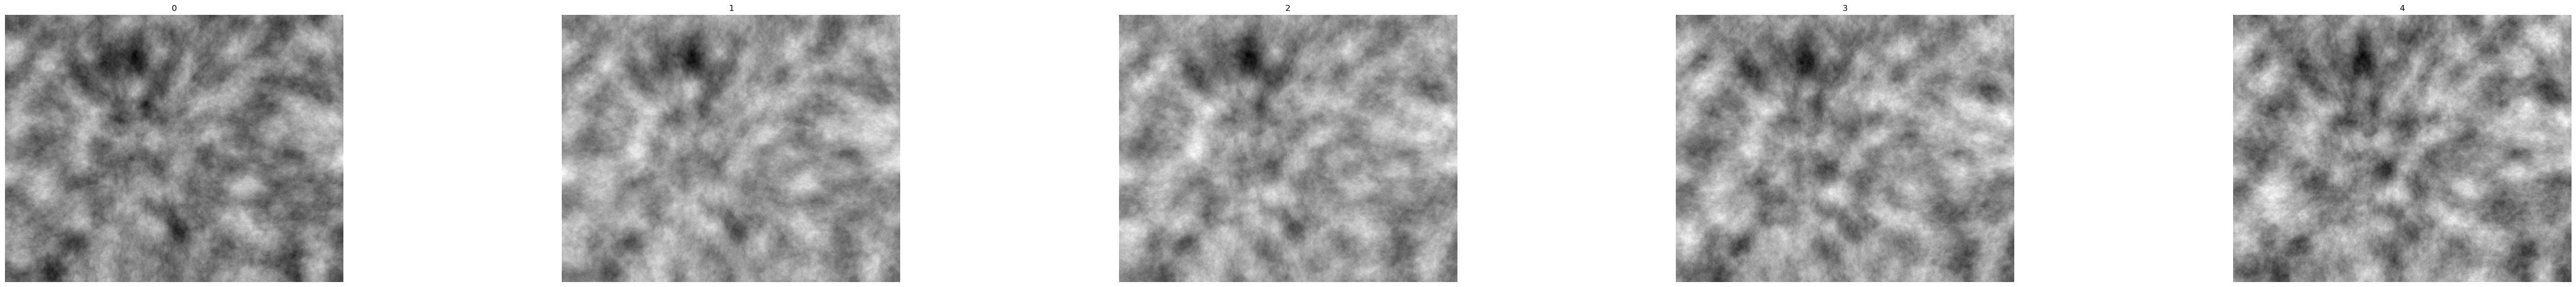

In [71]:
import h5py
fname = common_units.loc[idxs[0], 'file']

with h5py.File(RESULTS_DIR+fname, 'r') as hdf:
    unit = list(hdf.keys())[0]
    sta_grid = hdf[unit]['frames'][:]


f, axs = plt.subplots(1, 5, figsize=(10*7, 7))

for i in range(5):
    # axs[j, i].imshow(sta_grid[i], cmap='gray', vmin=0, vmax=1)
    axs[i].axis('off')
    axs[i].set_title(i)
    axs[i].imshow(sta_grid[i], cmap='gray')
